# SageMaker Random Cut Forests

***Random Cut Forestを利用した時系列データにおける異常検知***

---

1. [はじめに](#Iはじめに)
1. [セットアップ](#セットアップ)
1. [学習](#学習)
1. [推論](#推論)
1. [おわりに](#おわりに)

# はじめに
***


Amazon SageMaker Random Cut Forest (RCF) は異常検知のためのアルゴリズムです。異常検知は、例えば、ウェブサイトのトラフィックの予期せぬスパイクや、例年とは異なる温度の変化、想定外の公共交通機関の混雑などを検知するといった利用例があります。

このノートブックでは、異常検知のベンチーマークとして用いられるNew York Cityのタクシーデータセットを使い、RCFによって異常スコアを計算し、通常とは異なるイベントを検知します。RCFに関する詳しいドキュメントは[SageMaker RCF Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html)を参照してください。

# セットアップ

## データのダウンロード

New York Cityのタクシーデータセットをダウンロードして`./data`のフォルダにデータを保存します。今回使用するデータは、タクシーの乗客数を30分ごとにカウントした`nyc_taxi.csv`というファイルを利用します。

In [1]:
%%time
import os
import pandas as pd
import urllib.request
    
data_dir = 'data/'
data_filename = 'nyc_taxi.csv'
data_source = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

urllib.request.urlretrieve(data_source, data_dir + data_filename)

CPU times: user 296 ms, sys: 119 ms, total: 415 ms
Wall time: 989 ms


## データをのぞいてみる

ダウンロードしたファイルをPandasで開き、matplotlibでグラフ化してみます。グラフ化すると、以下のことがわかると思います。
- データに周期性がある。細かい周期は1日です。
- 6000ステップのあたりに異常値がある。

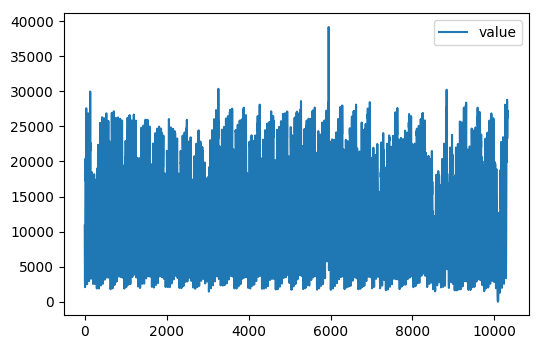

In [100]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

taxi_data = pd.read_csv(data_dir + data_filename, delimiter=',')
matplotlib.rcParams['figure.dpi'] = 100

taxi_data.plot()

## データのアップロード

SageMakerをJupyterとして使ってDeep Learningを行うことも可能ですが、**SageMaker Pyhon SDKによって、クラウドの強みを活かした効率のよい学習が可能です。** 
そのための準備として**学習に必要なデータをS3にアップロード**しましょう。これによって、このnotebookインスタンスよりも高性能なnotebookインスタンスを立ち上げて、S3からデータを取得して高速に学習する、といったことが可能になります。

以下では、SageMakerのセッション情報などを取得して、S3にファイルをアップロードします。ファイルを保存するためのS3のバケットは自動で作成され、バケット名がdefault_backet()によって自動設定されるsagemaker-{region}-{AWS account ID}で、prefixは`notebook/rcf/taxi`を指定しています。バケット名も自由に設定できますが、世界中で唯一の名前となるような設定が必要です。

In [3]:
import os
import sagemaker
import boto3


# Upload files to S3
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'notebook/rcf/taxi'
train_input = sess.upload_data(
        path=data_dir + data_filename, 
        key_prefix=prefix)

# Show S3 path 
print("Training data is uploaded to", train_input)


Training data is uploaded to s3://sagemaker-us-west-2-373011628954/notebook/rcf/taxi/nyc_taxi.csv


# 学習

## ハイパーパラメータ

RCFの主なハイパーパラメータは以下の通りです。

* **`num_samples_per_tree`** - RCFは異常検知のための複数の決定木を学習します。各決定木を学習する際、全ての学習データを使うのではなく、ランダムサンプリングを行って、一部の学習データを利用します。ここでは、サンプリングするデータの数を指定します。設定の目安として、異常の発生頻度が`1/num_samples_per_tree`と一致するように設定することが推奨されます。
* **`num_trees`** - 構築する決定木の数をここで指定します。適切な値は問題に依存しており、精度の良いモデルを作成するためには、いくつかの値を試す必要があります。決定木の数が多いと学習ならびに推論に時間がかかります。

## 学習の実行

RCFの学習を実行するため、上記のハイパーパラメータを指定してRandomCutForestを呼び出します。その際、学習データの位置やモデルの出力先、学習用インスタンス等を指定します。学習用インスタンスとして推奨されるのは、`ml.m4`, `ml.c4`, `ml.c5`で、いまのところGPUを考慮した処理は行っていません。

In [4]:
from sagemaker import RandomCutForest
from sagemaker import get_execution_role

# specify general training job information
rcf = RandomCutForest(role=get_execution_role(),
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location=('s3://{}/{}/'+data_dir).format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data.value.as_matrix().reshape(-1,1)))

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-01-06-04-23-08-931


2019-01-06 04:23:09 Starting - Starting the training job...
2019-01-06 04:23:11 Starting - Launching requested ML instances......
2019-01-06 04:24:12 Starting - Preparing the instances for training......
2019-01-06 04:25:29 Downloading - Downloading input data...
2019-01-06 04:26:09 Training - Training image download completed. Training in progress.
2019-01-06 04:26:09 Uploading - Uploading generated training model.
Docker entrypoint called with argument(s): train
[01/06/2019 04:26:06 INFO 139877231380288] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[01/06/2019 04:26:06 INFO 139877231380288

たくさんの情報が出力され、最終的に以下の情報が表示されると学習は完了です。
> `===== Job Complete =====`

以下のセルを実行すると、先ほど実行した学習ジョブの名前を確認することができます。東京リージョンの場合、以下のURLからジョブの一覧を確認できるので、学習ジョブの名前を選択することで詳細を見ることができます。もし異なるリージョンの場合は、以下のURLを開いた後、該当するリージョンへ変更すると確認できます。

https://ap-northeast-1.console.aws.amazon.com/sagemaker/home?region=ap-northeast-1#/jobs

In [5]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2019-01-06-04-23-08-931


# 推論

## エンドポイントの作成

学習したRCFを異常検知用に使ってみましょう。RCFでは入力データに対して異常スコアを出力するので、異常スコアにもとづいて異常を検知します。異常検知用のエンドポイントは、SageMaker Python SDKの`deploy()`を呼び出すことで作成できます。その際、エンドポイントのインスタンスを指定します。

In [6]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-01-06-04-26-51-365
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-01-06-04-23-08-931


---------------------------------------------------------------------------!

エンドポイントの作成が終わると、以下のセルからエンドポイントの名前を取得することができます。学習ジョブの一覧と同様にエンドポイントの一覧を下記のページから確認することができます。  
    
https://ap-northeast-1.console.aws.amazon.com/sagemaker/home?region=ap-northeast-1#/endpoints

In [7]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2019-01-06-04-23-08-931


## 異常を検知するデータの用意

エンドポイントができたら、何かデータを用意して異常検知を実行します。エンドポイントが受け取ることができるデータフォーマットは、ビルトインアルゴリズムによって異なり、RCFの場合はCSV, JSON, RecordIO Protobufになります。ここではCSVでデータをエンドポイントに送り、結果をjsonで受け取ることを考えます。そのために、SageMaker Python SDKの`csv_serializer`と`json_deserializer`を使います。

In [8]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

ダウンロードしたタクシーの乗客数のデータをnumpy arrayの形式に変換してpredictすると結果を得ることができます。numpy arrayを渡すと、上記で設定したserializerによってCSVとしてエンドポイントに渡されます。

出力されるjson形式の`score`から異常スコアを取得して、その結果を表示します。

In [9]:
taxi_data_numpy = taxi_data.value.as_matrix().reshape(-1,1)
results = rcf_inference.predict(taxi_data_numpy)

scores = [datum['score'] for datum in results['scores']]

# add scores to taxi data frame and print first few values
taxi_data['score'] = pd.Series(scores, index=taxi_data.index)
taxi_data.head()

,timestamp,value,score
0,2014-07-01 00:00:00,10844,0.934180
1,2014-07-01 00:30:00,8127,0.990971
2,2014-07-01 01:00:00,6210,0.916746
3,2014-07-01 01:30:00,4656,0.828762
4,2014-07-01 02:00:00,3820,0.899527


わかりやすいように、以下のセルを実行して、乗客数と異常スコアを同じグラフに表示してみます。6000ステップあたりの大量の乗客数は、やはり異常スコアが高く出ています。一方、乗客が多いからといって、かならずしも異常スコアが高いとは限りません。

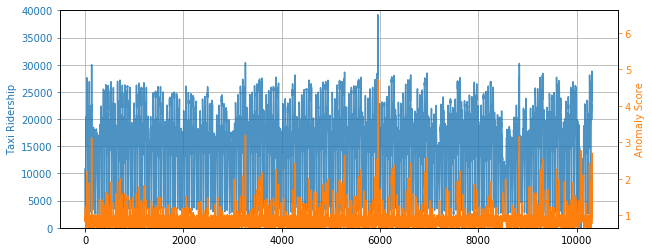

In [10]:
%matplotlib inline

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
#start, end = 5500, 6500
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset['value'], color='C0', alpha=0.8)
ax2.plot(taxi_data_subset['score'], color='C1')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

異常スコアの降順でソートして、異常スコアのTop-10を表示してみます。この期間には、11/2のNYCマラソンや、1/1のNew Yearが含まれており、いくつかの異常はこのような特定のイベントと関連していることがわかります。

In [11]:
taxi_data_subset.sort_values('score', ascending=False).head(10)

,timestamp,value,score
5954,2014-11-02 01:00:00,39197,4.723993
5955,2014-11-02 01:30:00,35212,4.133120
3262,2014-09-06 23:00:00,30373,3.195891
3261,2014-09-06 22:30:00,30313,3.180331
8834,2015-01-01 01:00:00,30236,3.162533
134,2014-07-03 19:00:00,29985,3.120748
8833,2015-01-01 00:30:00,29547,2.960563
10086,2015-01-27 03:00:00,8,2.774564
10088,2015-01-27 04:00:00,9,2.769046
10087,2015-01-27 03:30:00,11,2.768259


## エンドポイントの削除

エンドポイントは実行していると課金がされますので、以下のセルを実行して不要なエンドポイントを削除します。

In [12]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2019-01-06-04-23-08-931


# RCFの応用ならびに改善（オプション）

---

## RCFの応用
RCFはタクシーの乗客者数における異常検知のように、ある乗客数に対してそれが異常かどうかの判断を行うことができます。一方で、乗客数のトレンドがいつ変化したか、といった異常も検知することができます。


## RCFの改善
RCFの性能を向上させる方法として、学習モデルを正常とおもわれるデータのみで構成して学習させる方法があります。そうすることで、異常検知の際に、学習した正常のデータから大きく外れるので、精度が改善すると考えられます。

またもう一つの手法としてスライディングウィンドウを利用する方法があります。タクシーの乗客者数の場合、RCFの学習では全期間からランダムにデータをサンプリングしていましたが、そうするとサンプリングしたデータの周期性を見失う可能性があります。そこで時系列データを、長さ$P$ステップの連続するデータで切り出すスライディングウィンドウを利用し、連続するデータからランダムでデータをサンプリングする方法をとります。以降のセルでは、その前処理を実行してRCFを学習します。

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [13]:
import numpy as np

def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data-shingle_size, shingle_size))
    
    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n:(n+shingle_size)]
    return shingled_data

# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = 'sagemaker/randomcutforest_shingled'
taxi_data_shingled = shingle(taxi_data.values[:,1], shingle_size)
print(taxi_data_shingled)

[[10844.  8127.  6210. ... 21733. 20104. 16111.]
 [ 8127.  6210.  4656. ... 20104. 16111. 13370.]
 [ 6210.  4656.  3820. ... 16111. 13370.  9945.]
 ...
 [26874. 26928. 26000. ... 23719. 24670. 25721.]
 [26928. 26000. 25778. ... 24670. 25721. 27309.]
 [26000. 25778. 23304. ... 25721. 27309. 26591.]]


## 学習

In [14]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=get_execution_role(),
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix_shingled),
                      output_path='s3://{}/{}/output'.format(bucket, prefix_shingled),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data_shingled))

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-01-06-04-33-13-266


2019-01-06 04:33:13 Starting - Starting the training job...
2019-01-06 04:33:15 Starting - Launching requested ML instances.........
2019-01-06 04:34:44 Starting - Preparing the instances for training.........
2019-01-06 04:36:21 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[01/06/2019 04:36:54 INFO 139899356018496] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[01/06/2019 04:36:54 INFO 139899356018496] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'mini_batch_size': u'1000', u'feature_dim': u'48', u'num_samples_per

## エンドポイントの作成

学習したRCFを異常検知用に使うため、エンドポイントを作成します。

In [15]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'appliation/json'
rcf_inference.deserializer = json_deserializer

INFO:sagemaker:Creating model with name: randomcutforest-2019-01-06-04-37-25-636
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-01-06-04-33-13-266


--------------------------------------------------------------------------!

## 推論の実行

先程と同様に推論を実行します。推論に利用するデータが、スライディングウィンドウをこ``

In [101]:
results = rcf_inference.predict(taxi_data_shingled)

scores = [datum['score'] for datum in results['scores']]

# add scores to taxi data frame and print first few values
taxi_data['score'] = pd.Series(scores)

# Anomaly will be detected in one day because last data for 1 day is used for anomaly detection. 
taxi_data['timestamp'] = pd.to_datetime(taxi_data['timestamp']) + pd.DateOffset(days=1)
taxi_data.head()

,timestamp,value,score
0,2014-07-02 00:00:00,10844,0.957953
1,2014-07-02 00:30:00,8127,0.986775
2,2014-07-02 01:00:00,6210,0.930641
3,2014-07-02 01:30:00,4656,0.931356
4,2014-07-02 02:00:00,3820,0.908813


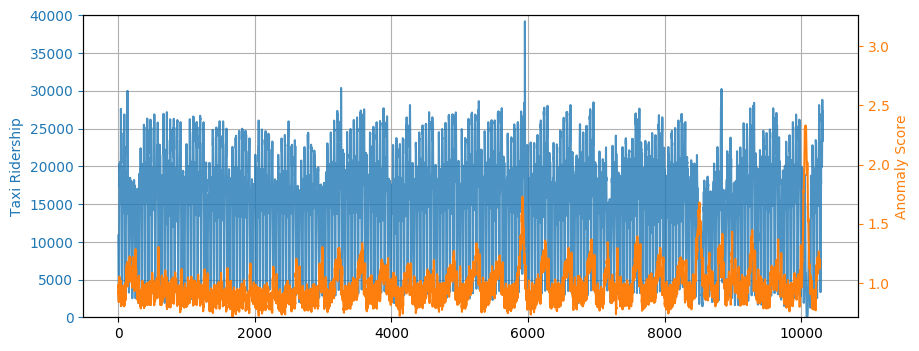

In [102]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data['value'], color='C0', alpha=0.8)
ax2.plot(scores, color='C1')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [103]:
taxi_data_subset.sort_values('score', ascending=False).head(10)

,timestamp,value,score
10064,2015-01-27 16:00:00,6257,2.328959
10066,2015-01-27 17:00:00,5159,2.325595
10067,2015-01-27 17:30:00,5283,2.325502
10065,2015-01-27 16:30:00,5520,2.323015
10068,2015-01-27 18:00:00,5821,2.322631
10058,2015-01-27 13:00:00,14402,2.317929
10069,2015-01-27 18:30:00,5586,2.317304
10063,2015-01-27 15:30:00,7681,2.315415
10057,2015-01-27 12:30:00,14428,2.315281
10070,2015-01-27 19:00:00,4729,2.313340


## 異常箇所の分析

2015年の1月27日の異常スコアが軒並み高くなっています。これはスライディングウィンドウを使わなかった場合は検出できていませんでした。そこで、1月26日から1月30日までの乗客数をグラフ化して見てみます。DataFrameのインデックスの10000から10239が、この5日間のデータに対応しており、異常スコアの高い1月27日は10048から10097までに対応してます。

5日間のデータをグラフ化してみると、1月27日を除く4日間は21時頃から乗客数の落ち込みが見られますが、1月27日の乗客数は終日低調です。この状況が異常として検出されていることがわかります。

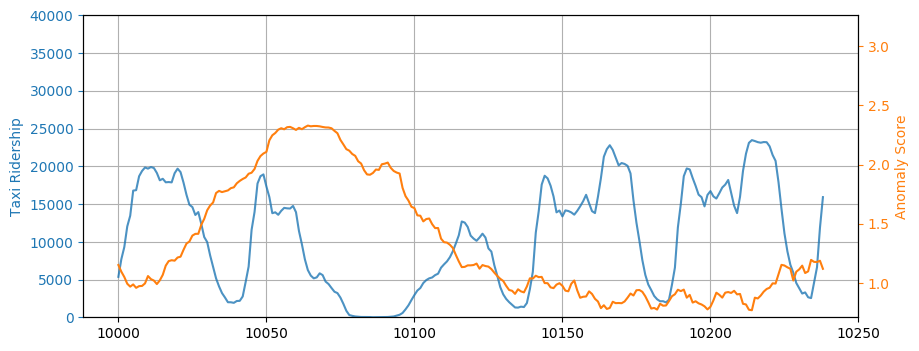

In [109]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 10000, 10239
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data_subset['value'], color='C0', alpha=0.8)
ax2.plot(taxi_data_subset['score'], color='C1')

ax1.grid(which='major', axis='both')
ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')
ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

## エンドポイントの削除

エンドポイントは実行していると課金がされますので、以下のセルを実行して不要なエンドポイントを削除します。

In [ ]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)